## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

train, test = keras.datasets.cifar10.load_data()

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

Using TensorFlow backend.


In [2]:
from keras.layers import Input, Dense, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):    
    """
    Build your own model
    """
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

## 1.試比較 save_best_only 與否的差異

In [3]:
## 超參數設定
"""
Set your hyper-parameters
"""
epochs = 50
batch_size = 256
save_best_only = [True, False]

In [5]:
results = {}
# 載入 Callbacks
"""
Write your training loop and show the results
"""
from keras.callbacks import EarlyStopping, ModelCheckpoint

for sbo in save_best_only:
    earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
    model_ckpt = ModelCheckpoint(filepath=f'./keras_save/save_best_only = {sbo}.h5', monitor="val_loss", save_best_only=sbo)
    """
    Your Training loop and Plot the results
    """
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print(f'save_best_only = {sbo}')
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=0.01, nesterov=True, momentum=0.95)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, 
              callbacks=[earlystop, model_ckpt])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
        
    name_tag = f'save_best_only = {sbo}'
    
    # Load back
    model = keras.models.load_model(f'./keras_save/save_best_only = {sbo}.h5')
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    results[name_tag] = {'loss_loadback': loss_loadback, 'acc_loadback': acc_loadback, 'train-loss': train_loss, 
                         'valid-loss': valid_loss, 'train-acc': train_acc, 'valid-acc': valid_acc}

save_best_only = True
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________

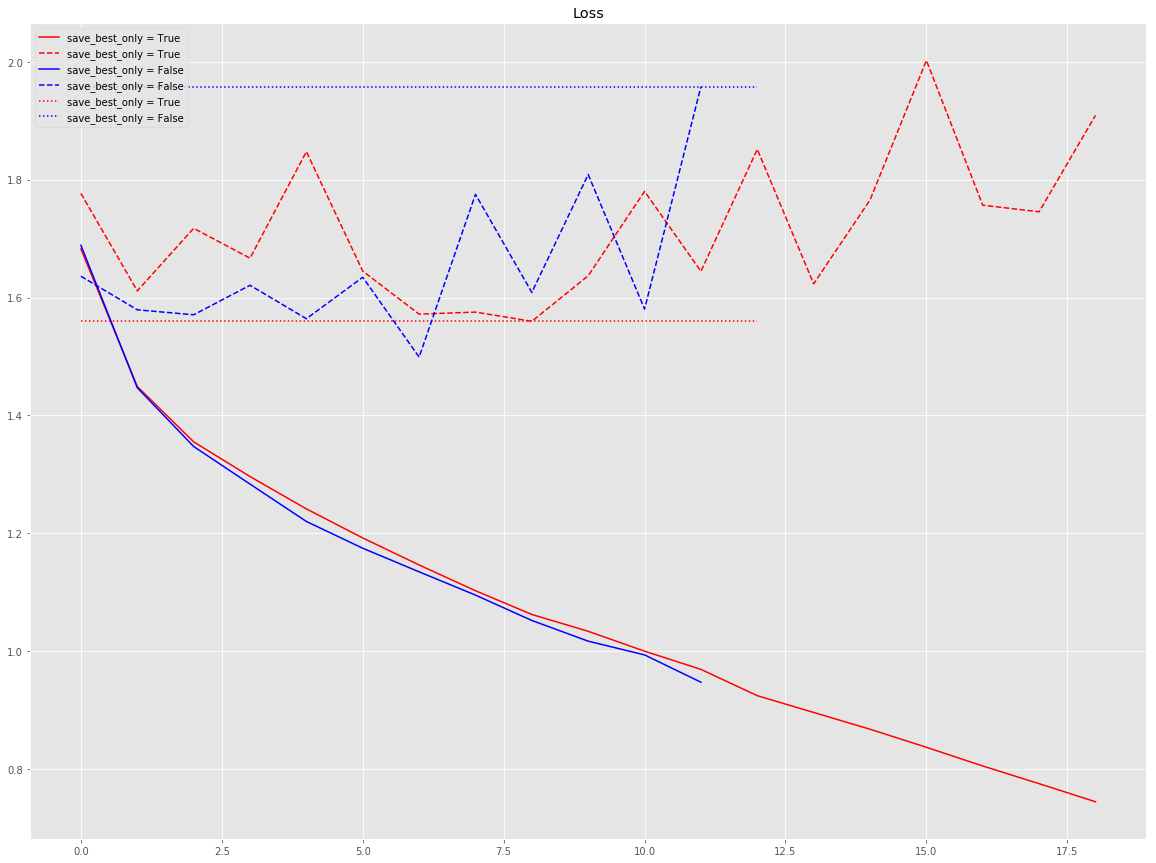

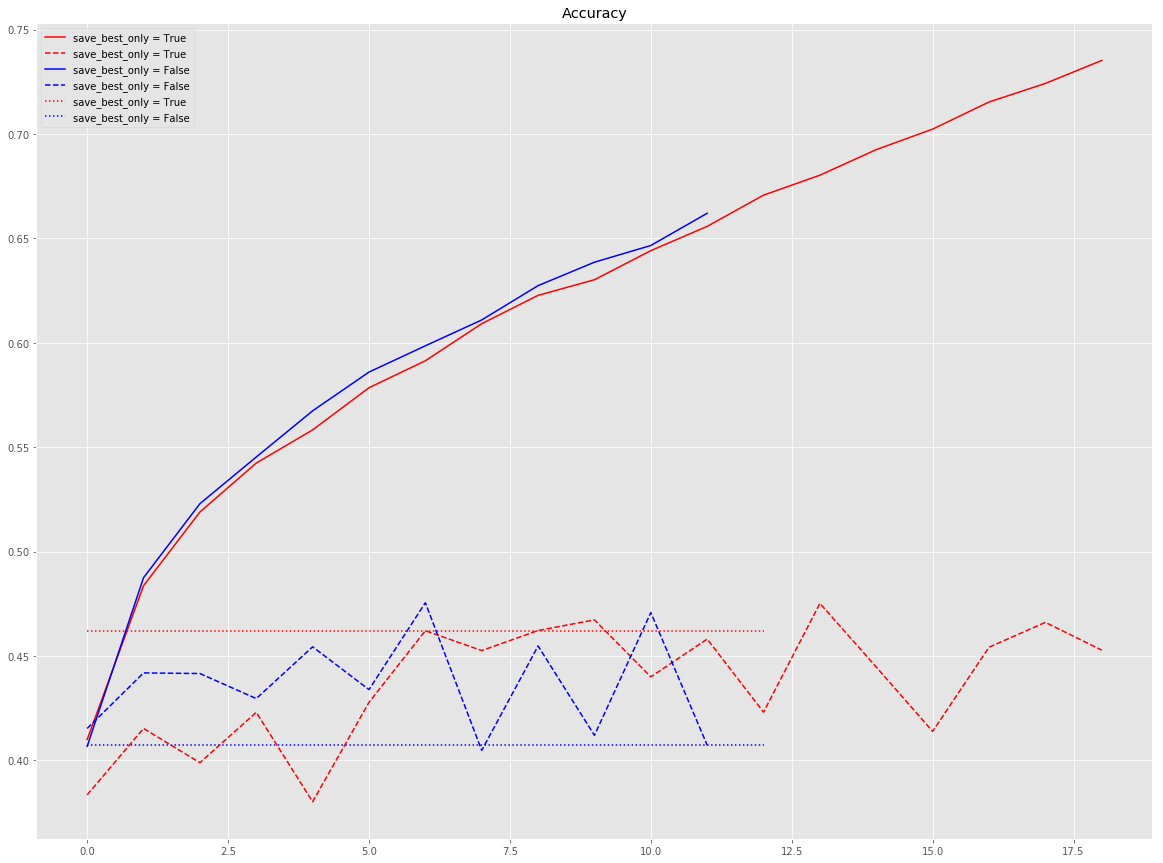

In [6]:
plt.style.use('ggplot')
color_bar = ['r', 'b']

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), linestyles=':', 
               label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), linestyles=':', 
               label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()